[Open in colab](https://colab.research.google.com/github/jkitchin/f21-06623/blob/master/practice/notebooks/pathological-events.ipynb)



## Pathological examples where solve\_ivp and events appear to fail



There are several ways that solving an ODE with \`scipy.integrate.solve\_ivp\` can go wrong. Here we examine a few of them.



### Missing events



\`solve\_ivp\` can miss events if the integration steps are too large. That happens because event detection requires a change in sign of the event function. Here we are counting the roots of a cubic polynomial. There should be three roots, but this code only finds one.



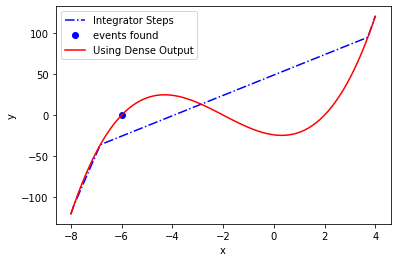

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

def fprime(x, y):
    return 3 * x**2 + 12 * x - 4

def event(x, y):
    return y

xspan = (-8, 4)

sol = solve_ivp(fprime, xspan, np.array([-120]), events=[event],
                dense_output=True)

xeval = np.linspace(*xspan, 100)

plt.plot(sol.t, sol.y[0], 'b-.', label='Integrator Steps')
plt.plot(sol.t_events[0], sol.y_events[0], 'bo', label='events found')
plt.plot(xeval, sol.sol(xeval)[0], 'r-', label='Using Dense Output')
plt.legend()
plt.xlabel('x')
plt.ylabel('y');

The ODE solution is not wrong; the final value is correct, the solution is sparse, and did not sample the intermediate regions, so no sign change was detected, and two events were missed.

You can see the event does only change sign once, so only one event is detected.



In [1]:
event(sol.t, sol.y)

array([[-120.        , -110.49687882,  -35.93785936,   94.46893375,
         120.        ]])

Using t\_eval *does not help* because it does not change where the integrator takes steps.



Text(0, 0.5, 'y')

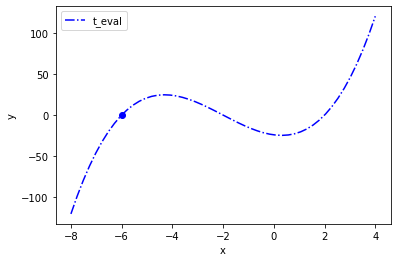

In [1]:
sol = solve_ivp(fprime, xspan, np.array([-120]), events=[event],
                t_eval=np.linspace(*xspan))

plt.plot(sol.t, sol.y[0], 'b-.', label='t_eval')
plt.plot(sol.t_events[0], sol.y_events[0], 'bo')
plt.legend()
plt.xlabel('x')
plt.ylabel('y');

Solve this problem by setting a max\_step to avoid taking too large of a step.



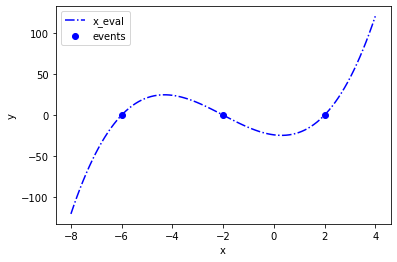

By ensuring you don't too large a step, you force the integrator not to miss the events.



## Big steps missing part of the solution



Adapted from [https://github.com/scipy/scipy/issues/9228#issuecomment-687561371](https://github.com/scipy/scipy/issues/9228#issuecomment-687561371)

In this example, we have a discontinuous ODE where the derivative is zero up to t=2, then it is constant to t=7, and then it is zero again. The solution should be zero up to t=2, then a line to t=7, and then a constant again.

This pathological example will fail with a method that tries several steps where the solution is constant, and then because the solution isn't changing, takes a large step past the region of change to the region where it is constant again.



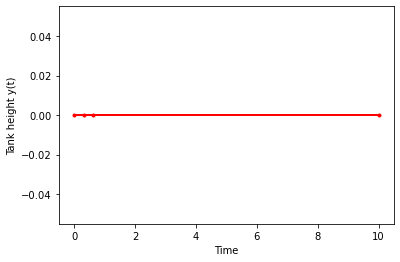

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def dydt(t, y):
  if t <= 2:
    return 0
  elif (t > 2) and (t < 7):
    return 5.0
  else:
    return 0

tspan = (0, 10)
y0 = [0]

sol = solve_ivp(dydt, tspan, y0, method='LSODA')

plt.plot(sol.t, sol.y.T, 'r.-', linewidth=2, label='')
plt.xlabel('Time')
plt.ylabel('Tank height y(t)');

That doesn't make sense. We start at 0, and if t is less than 2, nothing happens, dy/dt is zero, but between t = 2 to 7, dy/dt is a constant, so the tank height should increase linearly, and after that remain constant. The problem here is the first few points don't change, so the integrator takes a large step past t=7, where it is constant again. Solve this by again specifying a max\_step to avoid this.



Text(0, 0.5, 'Tank height y(t)')

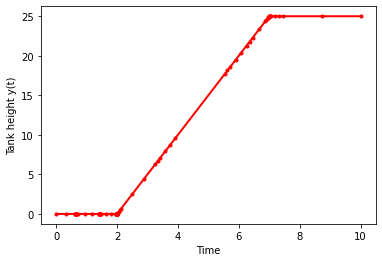

Note, this behavior is solver dependent, since the solver determines the step size. If you use the default solver, you do not see this behavior, although it does not capture the sharp corner at t=7, again because it took too large a step there.



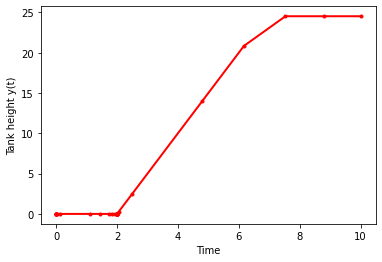

In [1]:
sol = solve_ivp(dydt, tspan, y0)

plt.plot(sol.t, sol.y.T, 'r.-', linewidth=2, label='')
plt.xlabel('Time')
plt.ylabel('Tank height y(t)');

## Wiggles with t\_eval



`t_eval` causes the solution to be interpolated from the known solution points. That can lead to wiggles in flat regions that are not real.



The solver successfully reached the end of the integration interval.

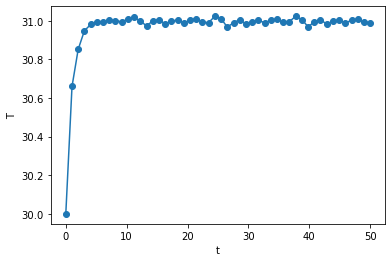

In [1]:
def dTdt(t, T):
    return (30 - T) + 1

T0 = np.array([30])
tspan = np.array((0, 50))
sol = solve_ivp(dTdt, tspan, T0, t_eval=np.linspace(*tspan))

import matplotlib.pyplot as plt

plt.plot(sol.t, sol.y.T,'o-')
plt.xlabel('t')
plt.ylabel('T')
sol.message

:END:

Those wiggles are not correct. One way to correct this again by ensuring that you don't allow the max\_step to be too large.



    The solver successfully reached the end of the integration interval.

![img](./.ob-jupyter/c391cf830966d919e072765a188b5271434946c4.png)



## Solutions



[Open in colab](https://colab.research.google.com/github/jkitchin/f21-06623/blob/master/practice/solutions/pathological-events.ipynb)

